In [1]:
from IPython.display import HTML

#This code bit is directly taken from this notebook: https://www.kaggle.com/agodwinp/stacking-house-prices-walkthrough-to-top-5/notebook
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
plt.style.use('seaborn-darkgrid')
print('Packages imported.')

Packages imported.


# Index

1. [First Look At the Data](#First-Look-At-the-Data)
   * [Sample Period](#Sample-Period)
   * [Duplicates](#Duplicates)
   * [Missing Observations](#Missing-Observations)
   * [Some Facts About Buyers and Recommenders](#Some-Facts-About-Buyers-and-Recommenders)
   * [Recommendation Chains / Networks](#Recommendation-Chains-/-Networks)
   * [Weekdays](#Weekdays)
   * [Time of Day](#Time-of-Day)
   * [From Trial to Purchase](#From-Trial-to-Purchase)
2. [Hearsay Recommendations](#Hearsay-Recommendations)
3. [Impact of the Super Bowl](#Impact-of-the-Super-Bowl)
4. [From Recommender to Buyer Trial](#From-Recommender-to-Buyer-Trial)

# First Look At the Data

In [3]:
data = pd.read_excel('data.xlsx')
print('Data loaded.')

Data loaded.


In [4]:
data.head()

,buyer_purchase_ts,buyer_id,recommender_id,buyer_trial_start_ts,recommender_trial_start_ts
0,2015-01-06 20:18:00,58dcaf1b05f0b9574d38775790eaef5d,527e9d8a5d103df8f925469224b64ad3,2014-04-30 12:08:00,2014-07-25 12:01:00
1,2015-02-12 19:40:00,681a885337cd9488593102503ab86642,044c537fbbe9f4202391ddd0749d0582,2014-02-17 12:58:00,NaT
2,2015-02-23 12:16:00,5c4144de045a798b4ecf69da734969c4,78edc5e188e8a58f9981abf246350a88,2012-08-09 20:42:00,NaT
3,2015-01-10 23:38:00,99b4d952b31658cc43dd8c8d92109572,1ed2d8d9692d092657d31eae43999c30,2014-07-21 17:36:00,NaT
4,2015-01-22 13:07:00,99b4d952b31658cc43dd8c8d92109572,1ed2d8d9692d092657d31eae43999c30,2014-07-21 17:36:00,NaT


In [5]:
print('The data set has {} entries.'.format(len(data)))

The data set has 16037 entries.


### Sample Period

In [6]:
data[['buyer_purchase_ts', 
      'buyer_trial_start_ts', 
      'recommender_trial_start_ts']
    ].describe().loc[['first', 'last'], :]

,buyer_purchase_ts,buyer_trial_start_ts,recommender_trial_start_ts
first,2015-01-01 00:05:00,2012-02-07 18:04:00,2011-10-21 10:33:00
last,2015-02-28 23:58:00,2015-12-16 12:45:00,2016-01-16 14:27:00


We can see that
* we have data for two months counting by the buyer purchase date
* buyers have started a trial outside this two months window, both before and after
* recommenders have started trials both before and after the two months window

### Duplicates

In [7]:
print('Number of duplicates: {}'.format(data.duplicated().sum()))

Number of duplicates: 56


An example of a duplicate:

In [8]:
data[data.duplicated(keep=False)].head(2)

,buyer_purchase_ts,buyer_id,recommender_id,buyer_trial_start_ts,recommender_trial_start_ts
233,2015-01-21 07:58:00,7f9d66e52496c8a68347b08ef86cfbc5,badd37e8870bdb5c83a62ad2fe288c37,2014-11-27 14:04:00,2014-10-08 15:14:00
234,2015-01-21 07:58:00,7f9d66e52496c8a68347b08ef86cfbc5,badd37e8870bdb5c83a62ad2fe288c37,2014-11-27 14:04:00,2014-10-08 15:14:00


I can come up with two reasons for this:
* This could be the result of a glitch, such as a double-click at the time of purchase. If this were the reason, we would probably be able to see a difference in ``buyer_purchase_ts`` at higher sampling frequency. 
* It could also be the result of purchasing two subscriptions at the same time.

Assuming that there are mechanisms in place to prevent double-click glitches, we keep the observations.

Another kind of duplicate arises for the trial start timestamps.

In [9]:
buy_nunq_trl = data.groupby('buyer_id').buyer_trial_start_ts.nunique()
rec_nunq_trl = data.fillna(-np.inf).groupby('recommender_id').recommender_trial_start_ts.nunique()
print('Buyers with multiple trials: {}'.format(
    (buy_nunq_trl > 1).sum()))
print('Recommenders with multiple trials: {}'.format(
    (rec_nunq_trl > 1).sum()))

Buyers with multiple trials: 1
Recommenders with multiple trials: 5


Looking at the buyer side:

In [10]:
data[data.buyer_id.isin(buy_nunq_trl[buy_nunq_trl > 1].index)]

,buyer_purchase_ts,buyer_id,recommender_id,buyer_trial_start_ts,recommender_trial_start_ts
757,2015-01-03 11:51:00,59df70121370227503e5e8eab42be282,690ec9132f5c9d5dac8f78b81a81ef12,2012-11-27 13:03:00,2014-08-07 13:45:00
758,2015-01-03 11:51:00,59df70121370227503e5e8eab42be282,690ec9132f5c9d5dac8f78b81a81ef12,2014-12-06 10:42:00,2014-08-07 13:45:00


This entry would likely constitute a single purchase, rather than two. Thus, we decide to drop one of the entries. Looking at the timestamps, it seems intuitive that the entry with the more recent trial start is more relevant to recommendation and purchase. Thus this is the entry we keep.

In [11]:
data.drop(757, inplace=True)
print('Entry dropped')

Entry dropped


Next, the recommender side:

In [12]:
data[data.recommender_id.isin(rec_nunq_trl[rec_nunq_trl > 1].index)].sort_values(['recommender_id', 'recommender_trial_start_ts'])

,buyer_purchase_ts,buyer_id,recommender_id,buyer_trial_start_ts,recommender_trial_start_ts
10887,2015-02-11 16:29:00,70acf1823d625cd82808d95968b89a3d,08949305e235bb699a78d5dbc2a41c4a,2015-02-04 16:14:00,2012-10-05 12:08:00
10888,2015-02-11 16:29:00,70acf1823d625cd82808d95968b89a3d,08949305e235bb699a78d5dbc2a41c4a,2015-02-04 16:14:00,2015-03-04 16:17:00
13840,2015-02-22 00:23:00,48fcc3d282372a0bc0f30c9efbff61c3,34de956d273b0744354913832bbd448a,2015-01-27 05:14:00,2014-10-01 23:43:00
13841,2015-02-22 00:23:00,48fcc3d282372a0bc0f30c9efbff61c3,34de956d273b0744354913832bbd448a,2015-01-27 05:14:00,2014-10-18 17:47:00
6826,2015-01-24 16:57:00,199a18f9d2f6e196c2e255396f7271d5,4d5bb9227a35002b5ccc959e90e5e394,2015-01-24 16:29:00,2012-09-29 17:04:00
6825,2015-01-24 16:57:00,199a18f9d2f6e196c2e255396f7271d5,4d5bb9227a35002b5ccc959e90e5e394,2015-01-24 16:29:00,2012-09-29 17:15:00
5627,2015-01-20 16:34:00,c1953ca6b090a009d5ec56952ae46e75,a9510422a34eb18d11dfacf02217dbff,2014-10-22 20:29:00,2014-12-26 18:42:00
5628,2015-01-20 16:34:00,c1953ca6b090a009d5ec56952ae46e75,a9510422a34eb18d11dfacf02217dbff,2014-10-22 20:29:00,2014-12-29 16:01:00
13419,2015-02-20 10:13:00,f4b0355a42e79ef25ad6c1e776c8c055,e7d1b1fb8f9d845772862faa9af3a9b8,2015-02-20 10:04:00,2014-11-28 16:12:00
13421,2015-02-20 10:17:00,f4b0355a42e79ef25ad6c1e776c8c055,e7d1b1fb8f9d845772862faa9af3a9b8,2015-02-20 10:04:00,2014-11-28 16:12:00


Except for one recommender, these different trial starts are mostly relatively close together, just hours or days apart.

Generally, we would like to use the recommender trial start as information about the recommender's knowledge of and experience with the product. A trial indicates at least some level of this. Thus, we decide to keep the more distant trial starts in this case.

In [13]:
data.drop([10888, 13841, 6825, 5628, 13420, 13422, 13424], inplace=True)
print('Entries dropped.')

Entries dropped.


### Missing Observations

In [14]:
pd.DataFrame(data.isnull().mean().rename('% of unavailable data')).T * 100

,buyer_purchase_ts,buyer_id,recommender_id,buyer_trial_start_ts,recommender_trial_start_ts
% of unavailable data,0.0,0.0,0.0,0.0,60.534032


The only unavailable data are for the trial start date of recommenders (~61%). 

This could be because
* these data are not available but do exist
* these recommenders never started a trial

Telling these two explanations apart would be of great interest. The latter relates to the extent of word of mouth recommendations through "hearsay". *For example, I might hear about the company on a podcast and recommend it to somebody who is in need of the product - even though I never used it myself.*

We revisit this below.

### Some Facts About Buyers and Recommenders

Buyers
------
Unique: 15614 
Multiple purchases: 345
Multiple purchase times: 257
Multiple recommenders: 144
Multiple recommenders at same purchase time: 43


Recommenders
------------
Unique: 15373
Recommended multiple buyers: 349
Listed for multiple purchases: 553




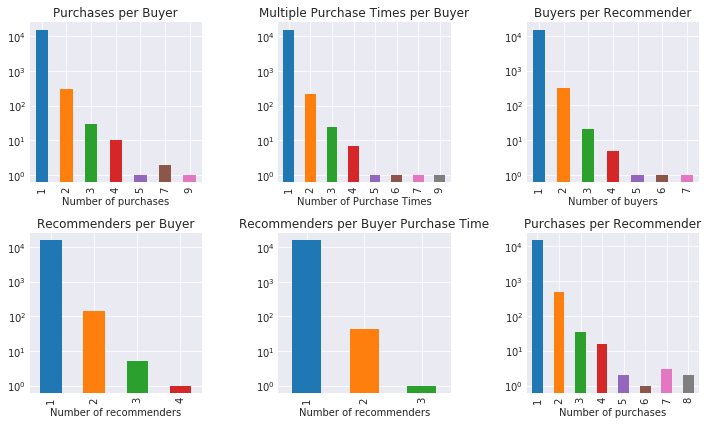

In [15]:
print('Buyers')
print('------')
print('Unique: {} '.format(data.buyer_id.nunique()))
print('Multiple purchases: {}'.format(
    (data.groupby('buyer_id').buyer_purchase_ts.count() > 1).sum()))
print('Multiple purchase times: {}'.format(
    (data.groupby('buyer_id').buyer_purchase_ts.nunique() > 1).sum()))
print('Multiple recommenders: {}'.format(
    (data.groupby('buyer_id').recommender_id.nunique() >1).sum()))
print('Multiple recommenders at same purchase time: {}'.format(
    (data.groupby(['buyer_id', 'buyer_purchase_ts']).recommender_id.nunique() > 1).sum()))
print('\n')


print('Recommenders')
print('------------')
print('Unique: {}'.format(data.recommender_id.nunique()))
print('Recommended multiple buyers: {}'.format(
    (data.groupby('recommender_id').buyer_id.nunique() > 1).sum()))
print('Listed for multiple purchases: {}'.format(
    (data.groupby('recommender_id').buyer_purchase_ts.count() > 1).sum()))
print('\n')

fig, ax = plt.subplots(ncols=3, nrows=2, figsize=(10,6))

data.groupby('buyer_id').buyer_purchase_ts.count().value_counts().sort_index().plot.bar(logy=True, ax=ax[0,0])
ax[0,0].set_title('Purchases per Buyer')
ax[0,0].set_xlabel('Number of purchases')

data.groupby('buyer_id').buyer_purchase_ts.nunique().value_counts().sort_index().plot.bar(logy=True, ax=ax[0,1])
ax[0,1].set_title('Multiple Purchase Times per Buyer')
ax[0,1].set_xlabel('Number of Purchase Times')

data.groupby('buyer_id').recommender_id.nunique().value_counts().sort_index().plot.bar(logy=True, ax=ax[1,0])
ax[1,0].set_title('Recommenders per Buyer')
ax[1,0].set_xlabel('Number of recommenders')

data.groupby(['buyer_id', 'buyer_purchase_ts']).recommender_id.nunique().value_counts().sort_index().plot.bar(logy=True, ax=ax[1,1])
ax[1,1].set_title('Recommenders per Buyer Purchase Time')
ax[1,1].set_xlabel('Number of recommenders')

data.groupby('recommender_id').buyer_id.nunique().value_counts().sort_index().plot.bar(logy=True, ax=ax[0,2])
ax[0,2].set_title('Buyers per Recommender')
ax[0,2].set_xlabel('Number of buyers')

data.groupby('recommender_id').buyer_purchase_ts.count().value_counts().sort_index().plot.bar(logy=True, ax=ax[1,2])
ax[1,2].set_title('Purchases per Recommender')
ax[1,2].set_xlabel('Number of purchases')
fig.tight_layout()

### Recommendation Chains / Networks

It would be interesting to see whether some of the buyers show up as recommenders later on. In this case, some ``buyer_id``s would also be ``recommender_id``s.

In [16]:
print('Are any buyer ids also recommender ids? {}'.format(
    data.buyer_id.isin(data.recommender_id).any()))

Are any buyer ids also recommender ids? False


This is not the case. Several possible reasons are
* The timespan is too short for buyers to transform into recommenders
* Recommended users are unlikely to recommend
* The anonymization was not done simultaneously for buyers and recommenders so the anonymized id's would not be identical even if they were before anonymization

### Weekdays

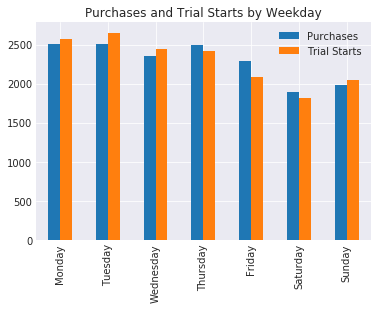

In [17]:
fig = pd.concat([
    data.buyer_purchase_ts.dt.weekday.value_counts().sort_index().rename('Purchases'),
    data.buyer_trial_start_ts.dt.weekday.value_counts().sort_index().rename('Trial Starts')
],
    axis=1).plot.bar()
fig.set_xticklabels(['Monday', 'Tuesday', 'Wednesday','Thursday','Friday','Saturday', 'Sunday'])
plt.title('Purchases and Trial Starts by Weekday')
plt.show()

* There is a general drop on weekends for both trials and purchases
* Mondays, Tuesday and Thursday have similar numbers of purchases, beating the other days. (What days feature TV or other ads?)

### Time of Day

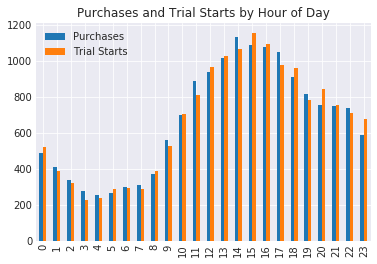

In [18]:
fig = pd.concat([
    data.buyer_purchase_ts.dt.hour.value_counts().sort_index().rename('Purchases'),
    data.buyer_trial_start_ts.dt.hour.value_counts().sort_index().rename('Trial Starts')],
    axis=1).plot.bar()
plt.title('Purchases and Trial Starts by Hour of Day')
plt.show()

Most purchases occur during daytime and the fewest during the night. (May indicate local timestamps or only US data.)

### From Trial to Purchase

In [19]:
buy_trl_to_prchs = data.buyer_purchase_ts - data.buyer_trial_start_ts

print('Share of Purchases before Trial: {:.2f}%'.format((buy_trl_to_prchs < pd.Timedelta('0ns')).mean() * 100))

Share of Purchases before Trial: 0.23%


The share of purchases before trial seems negligible.

In [20]:
buy_trl_to_prchs.describe()

count                       16029
mean      76 days 12:55:21.081789
std      165 days 10:52:41.348077
min           -309 days +02:45:00
25%               0 days 14:59:00
50%              10 days 23:09:00
75%              44 days 20:51:00
max            1105 days 21:53:00
dtype: object

* 25% of purchases occur within 15 hours of the trial start
* 50% of purchases occur within ~11 days of the trial start

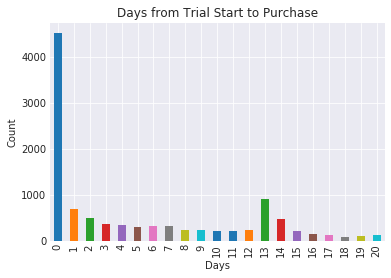

In [21]:
buy_trl_to_prchs.astype('timedelta64[D]').astype(int).value_counts().sort_index().loc[0:20].plot.bar()
plt.title('Days from Trial Start to Purchase')
plt.xlabel('Days')
plt.ylabel('Count')
plt.show()

There are spikes 13 and 14 days after trial start. The trial period is currently 14 days - looks like this was the case in 2015 as well. This would fit with the idea that a number of users would purchase right at the end of the trial.

# Hearsay Recommendations

We noted above that an unavailable timestamp for a recommender trial start may indicate that the recommender is not a customer.

We can also find such "hearsay" recommendations in the data. If the recommender starts the trial after the buyer, this would be a "hearsay" recommendation *(assuming that users generally do not start a trial after purchasing the product)*.

In [22]:
fltr_buy_trl_pre_rec_trl = data.buyer_trial_start_ts < data.recommender_trial_start_ts

print('Number of times recommender started trial after buyer: {}'.format(
    fltr_buy_trl_pre_rec_trl.sum()))

Number of times recommender started trial after buyer: 762


We can use this to produce a set estimate of "hearsay" recommendations.

First, we can assume that all unavailable data really relates to recommenders who signed up before the buyer. This allows an estimate for a lower bound of "hearsay" recommendations:

In [23]:
print('Estimated lower bound of "hearsay" recommendations: {:.2f}%'.format(
    fltr_buy_trl_pre_rec_trl.mean() * 100))

Estimated lower bound of "hearsay" recommendations: 4.75%


If we instead assume that the unavailable date is entirely due to "hearsay" recommendations, then we get an upper bound for the estimate:

In [24]:
up_lmt_hearsay = fltr_buy_trl_pre_rec_trl | data.recommender_trial_start_ts.isnull()
print('Estimated upper bound of "hearsay" recommendations: {:.2f}%'.format(
    (up_lmt_hearsay).mean() * 100))

Estimated upper bound of "hearsay" recommendations: 65.29%


This leaves us with a rather wide range.

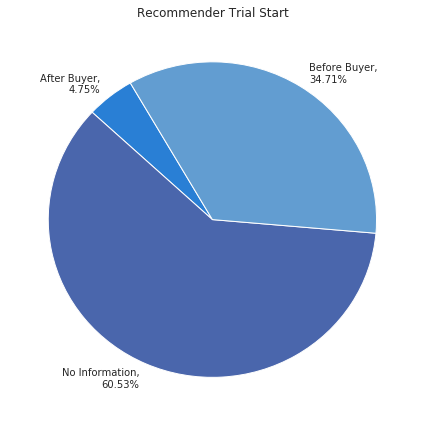

In [25]:
#matplotlib.rc('font', **{'size': 13})
pd.Series([fltr_buy_trl_pre_rec_trl.mean(), 
           data.recommender_trial_start_ts.isnull().mean(), 
          (~fltr_buy_trl_pre_rec_trl & data.recommender_trial_start_ts.notnull()).mean()],
          ['After Buyer,\n{:.2f}%'.format(fltr_buy_trl_pre_rec_trl.mean() * 100), 
           'No Information,\n{:.2f}%'.format(data.recommender_trial_start_ts.isnull().mean() * 100), 
           'Before Buyer,\n{:.2f}%'.format((~fltr_buy_trl_pre_rec_trl & data.recommender_trial_start_ts.notnull()).mean() * 100)
          ]).plot.pie(startangle=120,
                      colors=['#297fd5', '#4a66ac', '#629dd1'],
                      wedgeprops={"edgecolor":"w", 'antialiased': True}, figsize=(6,6))
plt.ylabel('')
#plt.axis('equal')
plt.title('Recommender Trial Start')
plt.tight_layout()
#plt.savefig('pie.png', dpi=150)

If we assume that the unavailable data is simply missing at random, for example because the buyer misspelled the recommender's e-mail address, then we can extrapolate the share of "hearsay" recommendations in the available data. This yields the following estimate:

In [26]:
print('Estimated missing at random share of "hearsay" recommendations: {:.2f}%'.format(
          fltr_buy_trl_pre_rec_trl.sum()/data.recommender_trial_start_ts.notnull().sum() * 100))

Estimated missing at random share of "hearsay" recommendations: 12.05%


While it seems likely that there is a mixed reason behind the unavailable data, my intuition would tell me that the data are not missing at random and may largely relate to recommenders who are not registered. However, this is certainly something to look into more with potentially large impact on the marketing strategy.

**Finding: up to 65% of recommenders may not (yet) be customers themselves**

**Hypothesis: Unavailable observations are largely due to "hearsay" recommendations** 

# Impact of the Super Bowl

Next, we look at purchases and trials over time. We limit our attention to the two months window for which we have purchase data.

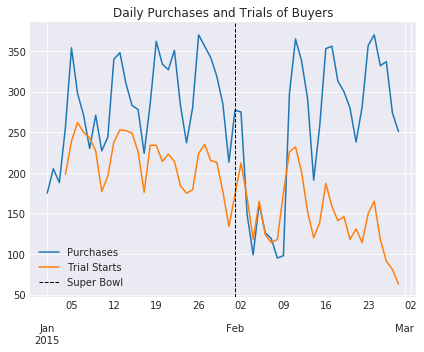

In [27]:
buyer_purchase_timeseries = data.buyer_purchase_ts.astype('datetime64[D]').value_counts().sort_index()
buyer_trial_timeseries = data.buyer_trial_start_ts.astype('datetime64[D]').value_counts()['2015-01-04':'2015-02-28'].sort_index()

#matplotlib.rc('font', **{'size': 13})
fig_ts, ax_ts = plt.subplots(figsize=(6,5))
pd.concat([buyer_purchase_timeseries.rename('Purchases'), buyer_trial_timeseries.rename('Trial Starts')], axis=1).plot(ax=ax_ts)
ax_ts.axvline('2015-02-01', color='black', linestyle='--', linewidth=1, label='Super Bowl')
ax_ts.set_title('Daily Purchases and Trials of Buyers')
plt.legend()
plt.tight_layout()
#plt.savefig('ts.png', dpi=150)
plt.show()

We can generally find a serrated pattern that is similar for both time series. This relates to our findings from purchases and trials grouped by weekday [above](#Weekdays). There, we saw that weekends are less active.

Interestingly, the number of purchases takes a dive after February 1, 2015 - the day of the Super Bowl. The company runs ads during the Super Bowl.

At first sight, this finding might be counterintuitive. However, customers are only in the data set if they
1. purchased between January 1 and February 28 of 2015 and
2. listed a recommender.

Thus, it seems more likely that merely the reported recommendations dropped after the Super Bowl Ad since people were already aware of the product because of the ad. This would be a crowding out effect.

*Remark: the lower level of the trial start time series and it's downward trend can be explained by the sampling. The lower level results since the number of trials and purchases in the data is roughly similar. However, trial starts range over a longer time so we would expect them to be at a lower level during the considered window. As for the downward slope, most purchases occur after trial and the data set only contains purchases until the end of February.*

**Finding: Super Bowl Ad leads to a drop in reported recommendations.**

**Hypothesis: Recommendation campaigns are less effective after alternative campaigns**

# From Recommender to Buyer Trial

We look at the number of buyers per recommender again.

In [28]:
print('Buyers per Recommender in %')
(pd.concat([
    data[data.isnull().any(axis=1)].groupby('recommender_id').buyer_id.nunique().value_counts(normalize=True).rename('Without Trial Data'),
    data.dropna().groupby('recommender_id').buyer_id.nunique().value_counts(normalize=True).rename('With Trial Data')
], axis=1).sort_index() * 100).round(2)

Buyers per Recommender in %


,Without Trial Data,With Trial Data
1,98.25,96.91
2,1.60,2.84
3,0.10,0.20
4,0.03,0.03
5,0.01,NaN
6,0.01,NaN
7,NaN,0.02


We can see that the vast majority of recommenders, both with without available data, recommended only one buyer (in the two months sample period).

Next, we take a look the duration from a recommender to a buyer trial. In the back of our head, we have the idea that the buyer trial sign-up is closely related to the time of recommendation.

*Remark: from [above](#From-Trial-to-Purchase) we can extrapolate that the results would mostly be shifted by a couple days when looking at buyer purchases rather than trial starts.*

In [29]:
lag_buy_trl_rec_trl = (data.buyer_trial_start_ts - data.recommender_trial_start_ts).dropna()

trl_pre_rec = (lag_buy_trl_rec_trl < pd.Timedelta('0ns'))
trl_same_day = (lag_buy_trl_rec_trl >= pd.Timedelta('0ns')) & (lag_buy_trl_rec_trl < pd.Timedelta('1D'))
trl_4_weeks = (lag_buy_trl_rec_trl >= pd.Timedelta('0ns')) & (lag_buy_trl_rec_trl < pd.Timedelta('28D'))
trl_year = (lag_buy_trl_rec_trl >= pd.Timedelta('0ns')) & (lag_buy_trl_rec_trl < pd.Timedelta('365D'))

print('Trial before recommender trial: {:.2f}%'.format(trl_pre_rec.mean()*100))
print('Trial within 24 hours of recommender trial: {:.2f}%'.format(trl_same_day.mean()*100))
print('Trial within 4 weeks of recommender trial: {:.2f}%'.format(trl_4_weeks.mean()*100))
print('Trial within 1 year of recommender trial: {:.2f}%'.format(trl_year.mean()*100))

Trial before recommender trial: 12.05%
Trial within 24 hours of recommender trial: 12.44%
Trial within 4 weeks of recommender trial: 19.02%
Trial within 1 year of recommender trial: 59.64%


We can see that many buyer trials follow soon after recommender trials.

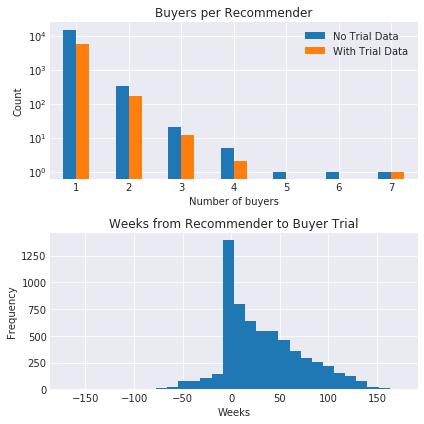

In [30]:
#matplotlib.rc('font', **{'size': 13})
fig_dly, ax_dly = plt.subplots(figsize=(6,6), nrows=2)

pd.concat([
    data.groupby('recommender_id').buyer_id.nunique().value_counts(normalize=False).rename('No Trial Data'),
    data.dropna().groupby('recommender_id').buyer_id.nunique().value_counts(normalize=False).rename('With Trial Data')
], axis=1).sort_index().plot.bar(logy=True, ax=ax_dly[0], rot=0)
ax_dly[0].set_title('Buyers per Recommender')
ax_dly[0].set_ylabel('Count')
ax_dly[0].set_xlabel('Number of buyers')

(lag_buy_trl_rec_trl.dropna()/pd.Timedelta('7D')).plot.hist(bins=30, ax=ax_dly[1])
ax_dly[1].set_title('Weeks from Recommender to Buyer Trial',)
ax_dly[1].set_xlabel('Weeks')
plt.tight_layout()
#plt.savefig('dly.png', dpi=150)
plt.show()

The histogram shows a steady decline in frequencies the further we move from the recommender trial start date. 

Taken together, it appears that recommenders are likely to recommend once soon after sign-up (note that these are only the recommendations leading to purchases). 

**Finding: Most buyers trial within a year of recommenders**

**Hypothesis: Recommenders need incentives to recommend again**